In [0]:
! nvidia-smi

Wed May 27 08:29:35 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import warnings
warnings.filterwarnings('ignore')
import zipfile
from zipfile import ZipFile
from pathlib import Path
from time import time
from datetime import datetime 
from __future__ import print_function
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from tqdm import tqdm
from PIL import Image
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import cv2
import pkgutil
import importlib
import os
%matplotlib inline
%config IPCompleter.greedy=True
%reload_ext autoreload
import seaborn as sns
import io
import skimage
from skimage.transform import resize
from itertools import groupby
from tqdm.auto import tqdm
import gc
sns.set()

#import albumentations
#print(albumentations.__version__) # check version

# This is to install and use albumentations latest package v0.4.5
#album_version_needed = "0.4.5"
#if albumentations.__version__ != album_version_needed:
#  !pip install albumentations==0.4.5   # 0.4.5 is the latest albumentation version
print('Pytorch version:', torch.__version__)

!pip install kornia
from kornia.losses import SSIM
from kornia.losses import DiceLoss

Pytorch version: 1.5.0+cu101


In [0]:
t1 = time()
!unzip -q "/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Mask_Depth/FG_BG_400K.zip"
!unzip -q "/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Mask_Depth/FG_BG_Mask_400K.zip"
!unzip -q "/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Mask_Depth/FG_BG_Depth_400K.zip"
!unzip -q "/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Mask_Depth/BG_and_Its_Flip.zip"
t2 = time()
print(f'FG_BG, Mask & Depth Copy took {(t2-t1)/60:.5f} minutes')

FG_BG, Mask & Depth Copy took 5.60334 minutes


In [0]:
if os.path.exists('/content/FG_BG_Filename_withflip_Logs.txt'):
    print('Log file exists')    
else:  
    !cp '/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Mask_Depth/FG_BG_Filename_withflip_Logs.txt' '/content/'
    print('Copied Log File')

Copied Log File


In [0]:
# Copying the code from github to colab
os.chdir('/content/')
!git clone https://github.com/anilbhatt1/EVA4P1_S15B_Depth_FG_Detection

Cloning into 'EVA4P1_S15B_Depth_FG_Detection'...
remote: Enumerating objects: 102, done.
remote: Counting objects: 100% (102/102), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 280 (delta 53), reused 0 (delta 0), pack-reused 178
Receiving objects: 100% (280/280), 12.78 MiB | 12.76 MiB/s, done.
Resolving deltas: 100% (127/127), done.


In [0]:
%cd '/content/EVA4P1_S15B_Depth_FG_Detection/src'
! ls

/content/EVA4P1_S15B_Depth_FG_Detection/src
dataset  __init__.py  losses  models  utils


### Importing modules from github folders

In [0]:
os.chdir('/content/EVA4P1_S15B_Depth_FG_Detection/')
import src
from src.dataset import datatransforms as dtf
from src.dataset import makedata as md
from src.models  import S15_FGDepth_models as ntwk
from src.losses  import Train as Train
from src.losses  import Test  as Test
from src.utils   import Freeze_Layers as Freeze

In [0]:
log_fg_bg = open('/content/FG_BG_Filename_withflip_Logs.txt',"r")
content_list = log_fg_bg.readlines()
print('No: of records in log_fg_bg:',len(content_list))
print(content_list[0])
log_fg_bg.close()

data_root = Path('/content')
f1, f2, f3, f4 = data_root/'FG_BG_400K', data_root/'BG_and_Its_Flip', data_root/'FG_BG_Mask_400K',  \
                 data_root/'FG_BG_Depth_0_400K'

No: of records in log_fg_bg: 400000
Img_fg_bg_1.jpg,Img21.jpg,Image41.png,(192, 192, 108, 156, 51, 3, 159, 3, 51, 159, 159, 159)



In [0]:
bs       = 96
bs_small = 96
bs_large = 16
rows = 5
img_save, model_save = 1500, 500
t0k, t10k, t80k, t160k, t220k, t260k, t280k, t360k, t390k, t400k  = 0, 10000, 80000, 160000, 220000,\
                                                                             260000, 280000, 360000,\
                                                                                     390000, 400000

### Creating transforms. We are resizing images for faster training

In [0]:
transform_instance   = dtf.Transforms_custom()
before_norm_list     = [transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1)]

transform_mini     = transform_instance.data_transforms(64, 64, before_norm_list)
transform_small    = transform_instance.data_transforms(96, 96, before_norm_list)
transform_orig     = transform_instance.data_transforms(192, 192, before_norm_list)
transform_test     = transform_instance.test_transforms(64,64)

### Creating dataloader for each size of images (resized using transforms).

In [0]:
## For testing
train_ds_b1  = md.Makedata(f1, content_list, t0k,   t10k,  transform_mini)
train_ds_b2  = md.Makedata(f1, content_list, t0k,   t10k, transform_mini)
train_ds_b3  = md.Makedata(f1, content_list, t0k,   t10k, transform_mini)
train_ds_b4  = md.Makedata(f1, content_list, t0k,   t10k, transform_small)
train_ds_b5  = md.Makedata(f1, content_list, t0k,   t10k, transform_orig)
test_ds      = md.Makedata(f1, content_list, t390k, t400k, transform_test)

In [0]:
'''
train_ds_b1  = md.Makedata(f1, content_list, t0k,   t80k,  transform_mini)
train_ds_b2  = md.Makedata(f1, content_list, t80k,  t160k, transform_mini)
train_ds_b3  = md.Makedata(f1, content_list, t160k, t220k, transform_mini)
train_ds_b4  = md.Makedata(f1, content_list, t220k, t260k, transform_small)
train_ds_b5  = md.Makedata(f1, content_list, t260k, t280k, transform_orig)
test_ds      = md.Makedata(f1, content_list, t280k, t400k, transform_test)     

In [0]:
train_dl_b1  = DataLoader(train_ds_b1, batch_size = bs,       shuffle = True, pin_memory = True)
train_dl_b2  = DataLoader(train_ds_b2, batch_size = bs,       shuffle = True, pin_memory = True)
train_dl_b3  = DataLoader(train_ds_b3, batch_size = bs,       shuffle = True, pin_memory = True)
train_dl_b4  = DataLoader(train_ds_b4, batch_size = bs_small, shuffle = True, pin_memory = True)
train_dl_b5  = DataLoader(train_ds_b5, batch_size = bs_large, shuffle = True, pin_memory = True)
test_dl      = DataLoader(test_ds,     batch_size = bs,       shuffle = True, pin_memory = True)

### Doing a quick check if tensor shapes are as expected

In [0]:
images_b1 = next(iter(train_dl_b1))
images_b2 = next(iter(train_dl_b2))
images_b3 = next(iter(train_dl_b3))
images_b4 = next(iter(train_dl_b4))
images_b5 = next(iter(train_dl_b5))
images_ts = next(iter(test_dl))
print('B1:',[(k, v.shape) for k, v in images_b1.items()])
print('B2:',[(k, v.shape) for k, v in images_b2.items()])
print('B3:',[(k, v.shape) for k, v in images_b3.items()])
print('B4:',[(k, v.shape) for k, v in images_b4.items()])
print('B5:',[(k, v.shape) for k, v in images_b5.items()])
print('TS:',[(k, v.shape) for k, v in images_ts.items()])

B1: [('f1', torch.Size([96, 3, 64, 64])), ('f2', torch.Size([96, 3, 64, 64])), ('f3', torch.Size([96, 1, 64, 64])), ('f4', torch.Size([96, 1, 64, 64]))]
B2: [('f1', torch.Size([96, 3, 64, 64])), ('f2', torch.Size([96, 3, 64, 64])), ('f3', torch.Size([96, 1, 64, 64])), ('f4', torch.Size([96, 1, 64, 64]))]
B3: [('f1', torch.Size([96, 3, 64, 64])), ('f2', torch.Size([96, 3, 64, 64])), ('f3', torch.Size([96, 1, 64, 64])), ('f4', torch.Size([96, 1, 64, 64]))]
B4: [('f1', torch.Size([96, 3, 96, 96])), ('f2', torch.Size([96, 3, 96, 96])), ('f3', torch.Size([96, 1, 96, 96])), ('f4', torch.Size([96, 1, 96, 96]))]
B5: [('f1', torch.Size([16, 3, 192, 192])), ('f2', torch.Size([16, 3, 192, 192])), ('f3', torch.Size([16, 1, 192, 192])), ('f4', torch.Size([16, 1, 192, 192]))]
TS: [('f1', torch.Size([96, 3, 64, 64])), ('f2', torch.Size([96, 3, 64, 64])), ('f3', torch.Size([96, 1, 64, 64])), ('f4', torch.Size([96, 1, 64, 64]))]


In [0]:
imgs = images_ts['f1']

### Displaying images to see if images are coming out as expected

In [0]:
def show(tensors, figsize= (10,10), *args, **kwargs):
  grid_tensor = torchvision.utils.make_grid(tensors, *args, **kwargs)  
  grid_image  = grid_tensor.permute(1, 2, 0)
  plt.figure(figsize = figsize)
  plt.imshow(grid_image)
  plt.xticks([])  
  plt.yticks([])
  plt.show()

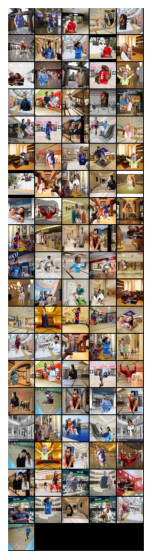

In [0]:
show(imgs, nrow=rows)

In [0]:
model = ntwk.FGDepth()
use_cuda = torch.cuda.is_available()
model.device = torch.device("cuda" if use_cuda else "cpu")
model.to(model.device)

FGDepth(
  (convA): Sequential(
    (0): Conv2d(6, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convB): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (convC): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convD): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (convE): Sequential(
    (0): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (blck1): DownSize(
  

In [0]:
freezer = Freeze.Freezer()

In [0]:
#criterion  = nn.BCEWithLogitsLoss()
criterion1  = DiceLoss()
kernel_size = 3
criterion2  = SSIM(kernel_size, reduction = 'mean')

optim = torch.optim.SGD(model.parameters(), lr=0.01, momentum = 0.9, weight_decay = 1e-5)

from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optim, step_size=2, gamma=0.1)

In [0]:
train_loss_fn = Train.Training_loss()
test_loss_fn  = Test.Testing_loss()

In [0]:
path = f'/content/gdrive/My Drive/FG_Depth_Prediction_0525V12B.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [0]:
### For Testing
path_name       = '/content/gdrive/My Drive/plots_0527_Test/'
path_model_save = f'/content/gdrive/My Drive/FG_Depth_Prediction_0527V13A.pt'

file_name  = 'train_log.txt'
log_file    = open(f'{path_name}{file_name}','w')
log_file.close()
file_name  = 'test_log.txt'
log_file   = open(f'{path_name}{file_name}','w') 
log_file.close()    

In [0]:
#### For Testing
train_loss_all, train_mask_loss_all, train_depth_loss_all, train_mask_iou_all, train_depth_iou_all = [], [], [], [], []
test_loss_all,  test_mask_loss_all,  test_depth_loss_all,  test_mask_iou_all,  test_depth_iou_all  = [], [], [], [], []

for epoch in range(1,11):
  train_loss, train_mask_loss, train_depth_loss, train_mask_iou, train_depth_iou = 0, 0, 0, 0, 0
  test_loss,  test_mask_loss,  test_depth_loss,  test_mask_iou,  test_depth_iou  = 0, 0, 0, 0, 0
  if epoch < 2:
     batch_size, loader = bs, train_dl_b1
     freezer.freeze_mask_layers(model)
  elif epoch < 3:
     batch_size, loader  = bs, train_dl_b2
     freezer.freeze_mask_layers(model)    
  elif epoch < 4:
     batch_size, loader = bs, train_dl_b3
     freezer.freeze_mask_layers(model)  
  elif epoch < 5:
     batch_size, loader  = bs_small, train_dl_b4
     freezer.freeze_mask_layers(model)  
  elif epoch < 6:
     batch_size, loader  = bs_large, train_dl_b5
     freezer.freeze_mask_layers(model)
  elif epoch < 7:
     batch_size, loader = bs,  train_dl_b1
     freezer.freeze_depth_layers(model)
  elif epoch < 8:
     batch_size, loader  = bs, train_dl_b2
     freezer.freeze_depth_layers(model) 
  elif epoch < 9:
     batch_size, loader  = bs, train_dl_b3
     freezer.freeze_depth_layers(model)  
  elif epoch < 10:
     batch_size, loader = bs_small, train_dl_b4
     freezer.freeze_depth_layers(model)  
  elif epoch < 11:
     batch_size, loader = bs_large, train_dl_b5
     freezer.freeze_depth_layers(model)      

  train_loss, train_mask_loss, train_depth_loss, train_mask_iou, train_depth_iou = train_loss_fn.train_loss_calc( \
                                                           model, model.device, loader,\
                                                           optim, epoch, criterion1, criterion2, batch_size, path_name, \
                                                           path_model_save, scheduler, model_save, img_save)
  batch_size, loader = bs, test_dl
  test_loss, test_mask_loss, test_depth_loss, test_mask_iou, test_depth_iou = test_loss_fn.test_loss_calc(             \
                                                         model, model.device, loader, optim,                           \
                                                         epoch, criterion1, criterion2, batch_size, path_name,         \
                                                         scheduler, img_save)
  scheduler.step()

  train_loss_all.append(train_loss.item()), train_mask_loss_all.append(train_mask_loss.item()), train_depth_loss_all.append(train_depth_loss.item())
  test_loss_all.append(test_loss.item()),   test_mask_loss_all.append(test_mask_loss.item()),   test_depth_loss_all.append(test_depth_loss.item())
  train_mask_iou_all.append(train_mask_iou), train_depth_iou_all.append(train_depth_iou)
  test_mask_iou_all.append(test_mask_iou),   test_depth_iou_all.append(test_depth_iou)

  gc.collect()

  0%|          | 0/105 [00:00<?, ?it/s]

Freezing Mask Layers


TR1|0|0.035|0.112|0.222|0.612:   0%|          | 0/105 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:1 Batch_ID: 0 [0/10000 (0%)]	Loss:0.18095 Mask_Loss:0.03455 Dpth_Loss:0.11184 Mask_IOU:0.22162 Dpth_IOU: 0.61232


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TR1|0|0.035|0.112|0.222|0.612:   1%|          | 1/105 [00:03<05:25,  3.13s/it]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0527V13A.pt Epoch & Batch-ID: 1 0


TR1|103|0.030|0.105|0.225|0.606:  98%|█████████▊| 103/105 [01:41<00:01,  1.05it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:1 Batch_ID: 103 [9888/10000 (98%)]	Loss:0.16479 Mask_Loss:0.03011 Dpth_Loss:0.10458 Mask_IOU:0.22525 Dpth_IOU: 0.60639


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TR1|104|0.024|0.120|0.190|0.639: 100%|██████████| 105/105 [01:43<00:00,  1.02it/s]
TS1|0|0.065|0.096|0.587|0.650:   0%|          | 0/105 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 1 [0/10000 (0%)]	Test_Loss: 0.226155 Mask_Loss: 0.06524 Dpth_Loss: 0.09568 Mask_IOU: 0.58691 Dpth_IOU: 0.64982


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TS1|103|0.066|0.099|0.571|0.629:  98%|█████████▊| 103/105 [01:13<00:01,  1.45it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 1 [515/10000 (98%)]	Test_Loss: 0.231714 Mask_Loss: 0.06641 Dpth_Loss: 0.09890 Mask_IOU: 0.57063 Dpth_IOU: 0.62912


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TS1|104|0.055|0.096|0.580|0.647: 100%|██████████| 105/105 [01:14<00:00,  1.41it/s]
  0%|          | 0/105 [00:00<?, ?it/s]

Freezing Mask Layers


TR2|0|0.039|0.107|0.263|0.610:   0%|          | 0/105 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:2 Batch_ID: 0 [0/10000 (0%)]	Loss:0.18598 Mask_Loss:0.03926 Dpth_Loss:0.10745 Mask_IOU:0.26292 Dpth_IOU: 0.61043


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TR2|0|0.039|0.107|0.263|0.610:   1%|          | 1/105 [00:02<05:10,  2.99s/it]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0527V13A.pt Epoch & Batch-ID: 2 0


TR2|103|0.045|0.102|0.310|0.649:  98%|█████████▊| 103/105 [01:41<00:01,  1.04it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:2 Batch_ID: 103 [9888/10000 (98%)]	Loss:0.19242 Mask_Loss:0.04497 Dpth_Loss:0.10249 Mask_IOU:0.31005 Dpth_IOU: 0.64931


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TR2|104|0.035|0.113|0.288|0.563: 100%|██████████| 105/105 [01:43<00:00,  1.02it/s]
TS2|0|0.064|0.092|0.563|0.654:   0%|          | 0/105 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 2 [0/10000 (0%)]	Test_Loss: 0.219587 Mask_Loss: 0.06388 Dpth_Loss: 0.09182 Mask_IOU: 0.56254 Dpth_IOU: 0.65373


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TS2|103|0.057|0.091|0.560|0.649:  98%|█████████▊| 103/105 [01:12<00:01,  1.48it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 2 [515/10000 (98%)]	Test_Loss: 0.205374 Mask_Loss: 0.05705 Dpth_Loss: 0.09128 Mask_IOU: 0.56003 Dpth_IOU: 0.64874


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TS2|104|0.054|0.084|0.562|0.693: 100%|██████████| 105/105 [01:14<00:00,  1.42it/s]
  0%|          | 0/105 [00:00<?, ?it/s]

Freezing Mask Layers


TR3|0|0.034|0.098|0.263|0.664:   0%|          | 0/105 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:3 Batch_ID: 0 [0/10000 (0%)]	Loss:0.16647 Mask_Loss:0.03423 Dpth_Loss:0.09801 Mask_IOU:0.26254 Dpth_IOU: 0.66443


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TR3|0|0.034|0.098|0.263|0.664:   1%|          | 1/105 [00:03<05:18,  3.06s/it]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0527V13A.pt Epoch & Batch-ID: 3 0


TR3|103|0.051|0.096|0.364|0.636:  98%|█████████▊| 103/105 [01:40<00:01,  1.05it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:3 Batch_ID: 103 [9888/10000 (98%)]	Loss:0.19811 Mask_Loss:0.05098 Dpth_Loss:0.09616 Mask_IOU:0.36379 Dpth_IOU: 0.63615


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TR3|104|0.050|0.089|0.416|0.618: 100%|██████████| 105/105 [01:43<00:00,  1.02it/s]
TS3|0|0.058|0.090|0.564|0.656:   0%|          | 0/105 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 3 [0/10000 (0%)]	Test_Loss: 0.207022 Mask_Loss: 0.05831 Dpth_Loss: 0.09041 Mask_IOU: 0.56372 Dpth_IOU: 0.65634


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TS3|103|0.061|0.091|0.591|0.654:  98%|█████████▊| 103/105 [01:12<00:01,  1.45it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 3 [515/10000 (98%)]	Test_Loss: 0.214175 Mask_Loss: 0.06147 Dpth_Loss: 0.09123 Mask_IOU: 0.59052 Dpth_IOU: 0.65352


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TS3|104|0.064|0.098|0.581|0.670: 100%|██████████| 105/105 [01:14<00:00,  1.41it/s]
  0%|          | 0/105 [00:00<?, ?it/s]

Freezing Mask Layers


TR4|0|0.037|0.141|0.245|0.457:   0%|          | 0/105 [00:01<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:4 Batch_ID: 0 [0/10000 (0%)]	Loss:0.21410 Mask_Loss:0.03656 Dpth_Loss:0.14099 Mask_IOU:0.24488 Dpth_IOU: 0.45711


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TR4|0|0.037|0.141|0.245|0.457:   1%|          | 1/105 [00:04<08:17,  4.78s/it]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0527V13A.pt Epoch & Batch-ID: 4 0


TR4|103|0.037|0.119|0.232|0.439:  98%|█████████▊| 103/105 [03:07<00:03,  1.78s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:4 Batch_ID: 103 [9888/10000 (98%)]	Loss:0.19259 Mask_Loss:0.03668 Dpth_Loss:0.11924 Mask_IOU:0.23250 Dpth_IOU: 0.43855


TR4|104|0.047|0.123|0.306|0.371: 100%|██████████| 105/105 [03:10<00:00,  1.82s/it]
TS4|0|0.059|0.107|0.558|0.534:   0%|          | 0/105 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 4 [0/10000 (0%)]	Test_Loss: 0.224683 Mask_Loss: 0.05880 Dpth_Loss: 0.10708 Mask_IOU: 0.55776 Dpth_IOU: 0.53391


TS4|103|0.066|0.107|0.570|0.552:  98%|█████████▊| 103/105 [01:13<00:01,  1.46it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 4 [515/10000 (98%)]	Test_Loss: 0.239300 Mask_Loss: 0.06627 Dpth_Loss: 0.10675 Mask_IOU: 0.56985 Dpth_IOU: 0.55245


TS4|104|0.063|0.105|0.561|0.589: 100%|██████████| 105/105 [01:14<00:00,  1.41it/s]
  0%|          | 0/625 [00:00<?, ?it/s]

Freezing Mask Layers


TR5|0|0.046|0.152|0.261|0.282:   0%|          | 0/625 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:5 Batch_ID: 0 [0/10000 (0%)]	Loss:0.24362 Mask_Loss:0.04604 Dpth_Loss:0.15153 Mask_IOU:0.26066 Dpth_IOU: 0.28231


TR5|0|0.046|0.152|0.261|0.282:   0%|          | 1/625 [00:02<30:19,  2.92s/it]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0527V13A.pt Epoch & Batch-ID: 5 0


TR5|500|0.058|0.113|0.277|0.140:  80%|████████  | 501/625 [09:49<02:54,  1.41s/it]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0527V13A.pt Epoch & Batch-ID: 5 500


TR5|624|0.035|0.116|0.279|0.133: 100%|█████████▉| 624/625 [12:14<00:01,  1.18s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:5 Batch_ID: 624 [9984/10000 (100%)]	Loss:0.18517 Mask_Loss:0.03476 Dpth_Loss:0.11566 Mask_IOU:0.27919 Dpth_IOU: 0.13281


TR5|624|0.035|0.116|0.279|0.133: 100%|██████████| 625/625 [12:16<00:00,  1.18s/it]
TS5|0|0.060|0.157|0.542|0.045:   0%|          | 0/105 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 5 [0/10000 (0%)]	Test_Loss: 0.275999 Mask_Loss: 0.05961 Dpth_Loss: 0.15679 Mask_IOU: 0.54170 Dpth_IOU: 0.04452


TS5|103|0.063|0.159|0.577|0.034:  98%|█████████▊| 103/105 [01:12<00:01,  1.47it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 5 [515/10000 (98%)]	Test_Loss: 0.284138 Mask_Loss: 0.06273 Dpth_Loss: 0.15867 Mask_IOU: 0.57654 Dpth_IOU: 0.03379


TS5|104|0.066|0.159|0.576|0.046: 100%|██████████| 105/105 [01:13<00:00,  1.42it/s]
  0%|          | 0/105 [00:00<?, ?it/s]

Freezing Depth Layers


TR6|0|0.038|0.130|0.242|0.258:   0%|          | 0/105 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:6 Batch_ID: 0 [0/10000 (0%)]	Loss:0.20667 Mask_Loss:0.03813 Dpth_Loss:0.13042 Mask_IOU:0.24230 Dpth_IOU: 0.25849


TR6|0|0.038|0.130|0.242|0.258:   1%|          | 1/105 [00:03<05:16,  3.04s/it]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0527V13A.pt Epoch & Batch-ID: 6 0


TR6|103|0.041|0.134|0.281|0.268:  98%|█████████▊| 103/105 [01:40<00:01,  1.06it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:6 Batch_ID: 103 [9888/10000 (98%)]	Loss:0.21640 Mask_Loss:0.04138 Dpth_Loss:0.13365 Mask_IOU:0.28100 Dpth_IOU: 0.26764


TR6|104|0.004|0.145|0.023|0.297: 100%|██████████| 105/105 [01:42<00:00,  1.03it/s]
TS6|0|0.060|0.127|0.569|0.253:   0%|          | 0/105 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 6 [0/10000 (0%)]	Test_Loss: 0.247655 Mask_Loss: 0.06032 Dpth_Loss: 0.12702 Mask_IOU: 0.56876 Dpth_IOU: 0.25275


TS6|103|0.060|0.130|0.561|0.282:  98%|█████████▊| 103/105 [01:12<00:01,  1.47it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 6 [515/10000 (98%)]	Test_Loss: 0.250037 Mask_Loss: 0.05999 Dpth_Loss: 0.13005 Mask_IOU: 0.56091 Dpth_IOU: 0.28202


TS6|104|0.068|0.139|0.535|0.303: 100%|██████████| 105/105 [01:14<00:00,  1.42it/s]
  0%|          | 0/105 [00:00<?, ?it/s]

Freezing Depth Layers


TR7|0|0.030|0.136|0.222|0.253:   0%|          | 0/105 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:7 Batch_ID: 0 [0/10000 (0%)]	Loss:0.19694 Mask_Loss:0.03050 Dpth_Loss:0.13595 Mask_IOU:0.22187 Dpth_IOU: 0.25280


TR7|0|0.030|0.136|0.222|0.253:   1%|          | 1/105 [00:02<05:09,  2.98s/it]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0527V13A.pt Epoch & Batch-ID: 7 0


TR7|103|0.028|0.130|0.226|0.260:  98%|█████████▊| 103/105 [01:40<00:01,  1.06it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:7 Batch_ID: 103 [9888/10000 (98%)]	Loss:0.18618 Mask_Loss:0.02815 Dpth_Loss:0.12988 Mask_IOU:0.22647 Dpth_IOU: 0.26043


TR7|104|0.051|0.149|0.428|0.316: 100%|██████████| 105/105 [01:42<00:00,  1.03it/s]
TS7|0|0.055|0.125|0.563|0.283:   0%|          | 0/105 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 7 [0/10000 (0%)]	Test_Loss: 0.234976 Mask_Loss: 0.05516 Dpth_Loss: 0.12465 Mask_IOU: 0.56297 Dpth_IOU: 0.28288


TS7|103|0.064|0.127|0.563|0.286:  98%|█████████▊| 103/105 [01:12<00:01,  1.45it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 7 [515/10000 (98%)]	Test_Loss: 0.254505 Mask_Loss: 0.06373 Dpth_Loss: 0.12705 Mask_IOU: 0.56323 Dpth_IOU: 0.28613


TS7|104|0.072|0.133|0.555|0.177: 100%|██████████| 105/105 [01:14<00:00,  1.41it/s]
  0%|          | 0/105 [00:00<?, ?it/s]

Freezing Depth Layers


TR8|0|0.045|0.129|0.332|0.306:   0%|          | 0/105 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:8 Batch_ID: 0 [0/10000 (0%)]	Loss:0.21858 Mask_Loss:0.04490 Dpth_Loss:0.12878 Mask_IOU:0.33227 Dpth_IOU: 0.30644


TR8|0|0.045|0.129|0.332|0.306:   1%|          | 1/105 [00:03<05:22,  3.10s/it]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0527V13A.pt Epoch & Batch-ID: 8 0


TR8|103|0.037|0.132|0.278|0.260:  98%|█████████▊| 103/105 [01:40<00:01,  1.05it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:8 Batch_ID: 103 [9888/10000 (98%)]	Loss:0.20647 Mask_Loss:0.03720 Dpth_Loss:0.13206 Mask_IOU:0.27769 Dpth_IOU: 0.25973


TR8|104|0.026|0.151|0.275|0.232: 100%|██████████| 105/105 [01:42<00:00,  1.02it/s]
TS8|0|0.063|0.123|0.575|0.250:   0%|          | 0/105 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 8 [0/10000 (0%)]	Test_Loss: 0.249726 Mask_Loss: 0.06328 Dpth_Loss: 0.12316 Mask_IOU: 0.57521 Dpth_IOU: 0.25018


TS8|103|0.060|0.126|0.563|0.299:  98%|█████████▊| 103/105 [01:12<00:01,  1.46it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 8 [515/10000 (98%)]	Test_Loss: 0.245250 Mask_Loss: 0.05958 Dpth_Loss: 0.12608 Mask_IOU: 0.56337 Dpth_IOU: 0.29906


TS8|104|0.060|0.120|0.541|0.398: 100%|██████████| 105/105 [01:14<00:00,  1.41it/s]
  0%|          | 0/105 [00:00<?, ?it/s]

Freezing Depth Layers


TR9|0|0.043|0.125|0.298|0.175:   0%|          | 0/105 [00:01<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:9 Batch_ID: 0 [0/10000 (0%)]	Loss:0.20973 Mask_Loss:0.04252 Dpth_Loss:0.12468 Mask_IOU:0.29752 Dpth_IOU: 0.17503


TR9|0|0.043|0.125|0.298|0.175:   1%|          | 1/105 [00:04<08:03,  4.65s/it]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0527V13A.pt Epoch & Batch-ID: 9 0


TR9|103|0.026|0.131|0.192|0.159:  98%|█████████▊| 103/105 [02:54<00:03,  1.65s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:9 Batch_ID: 103 [9888/10000 (98%)]	Loss:0.18342 Mask_Loss:0.02614 Dpth_Loss:0.13114 Mask_IOU:0.19200 Dpth_IOU: 0.15886


TR9|104|0.027|0.118|0.163|0.143: 100%|██████████| 105/105 [02:58<00:00,  1.70s/it]
TS9|0|0.061|0.141|0.551|0.047:   0%|          | 0/105 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 9 [0/10000 (0%)]	Test_Loss: 0.262448 Mask_Loss: 0.06070 Dpth_Loss: 0.14106 Mask_IOU: 0.55120 Dpth_IOU: 0.04719


TS9|103|0.065|0.138|0.568|0.052:  98%|█████████▊| 103/105 [01:12<00:01,  1.46it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 9 [515/10000 (98%)]	Test_Loss: 0.268120 Mask_Loss: 0.06511 Dpth_Loss: 0.13789 Mask_IOU: 0.56753 Dpth_IOU: 0.05227


TS9|104|0.058|0.143|0.552|0.031: 100%|██████████| 105/105 [01:13<00:00,  1.42it/s]
  0%|          | 0/625 [00:00<?, ?it/s]

Freezing Depth Layers


TR10|0|0.067|0.126|0.360|0.198:   0%|          | 0/625 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:10 Batch_ID: 0 [0/10000 (0%)]	Loss:0.26095 Mask_Loss:0.06734 Dpth_Loss:0.12627 Mask_IOU:0.36032 Dpth_IOU: 0.19801


TR10|0|0.067|0.126|0.360|0.198:   0%|          | 1/625 [00:02<29:35,  2.84s/it]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0527V13A.pt Epoch & Batch-ID: 10 0


TR10|500|0.033|0.122|0.232|0.126:  80%|████████  | 501/625 [09:05<02:40,  1.30s/it]

MODEL SAVED: /content/gdrive/My Drive/FG_Depth_Prediction_0527V13A.pt Epoch & Batch-ID: 10 500


TR10|624|0.046|0.134|0.255|0.146: 100%|█████████▉| 624/625 [11:19<00:01,  1.08s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch:10 Batch_ID: 624 [9984/10000 (100%)]	Loss:0.22685 Mask_Loss:0.04638 Dpth_Loss:0.13409 Mask_IOU:0.25522 Dpth_IOU: 0.14640


TR10|624|0.046|0.134|0.255|0.146: 100%|██████████| 625/625 [11:20<00:00,  1.09s/it]
TS10|0|0.062|0.160|0.560|0.025:   0%|          | 0/105 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 10 [0/10000 (0%)]	Test_Loss: 0.283149 Mask_Loss: 0.06165 Dpth_Loss: 0.15985 Mask_IOU: 0.55987 Dpth_IOU: 0.02504


TS10|103|0.068|0.164|0.545|0.034:  98%|█████████▊| 103/105 [01:13<00:01,  1.44it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Epoch: 10 [515/10000 (98%)]	Test_Loss: 0.300785 Mask_Loss: 0.06840 Dpth_Loss: 0.16399 Mask_IOU: 0.54462 Dpth_IOU: 0.03363


TS10|104|0.067|0.165|0.547|0.035: 100%|██████████| 105/105 [01:15<00:00,  1.40it/s]


In [0]:
'''
path_name       = '/content/gdrive/My Drive/plots_0527_V13A/'
path_model_save = f'/content/gdrive/My Drive/FG_Depth_Prediction_0525V13A.pt'
train_loss_all, train_mask_loss_all, train_depth_loss_all, train_mask_iou_all, train_depth_iou_all = [], [], [], [], []
test_loss_all,  test_mask_loss_all,  test_depth_loss_all,  test_mask_iou_all,  test_depth_iou_all  = [], [], [], [], []

for epoch in range(1,21):
  train_loss, train_mask_loss, train_depth_loss, train_mask_iou, train_depth_iou = 0, 0, 0, 0, 0
  test_loss,  test_mask_loss,  test_depth_loss,  test_mask_iou,  test_depth_iou  = 0, 0, 0, 0, 0
  if epoch < 7:
     batch_size = bs
     freeze_mask_layers()
     train_loss, train_mask_loss, train_depth_loss, train_mask_iou, train_depth_iou = train_loss_fn.train_loss_calc( \
                                                           model, model.device,train_dl_mini,\
                                                           optim, epoch, criterion1, criterion2, batch_size, path_name, \
                                                           path_model_save, scheduler, model_save, img_save)
  elif epoch < 10:
     batch_size = bs_small
     freeze_mask_layers()    
     train_loss, train_mask_loss, train_depth_loss, train_mask_iou, train_depth_iou = train_loss_fn.train_loss_calc(    \
                                                           model, model.device,train_dl_small,                          \
                                                           optim, epoch, criterion1, criterion2, batch_size, path_name, \
                                                           path_model_save, scheduler, model_save, img_save)
  elif epoch < 11:
     batch_size = bs_large
     freeze_mask_layers()    
     train_loss, train_mask_loss, train_depth_loss, train_mask_iou, train_depth_iou = train_loss_fn.train_loss_calc(    \
                                                           model, model.device,train_dl_orig,                           \
                                                           optim, epoch, criterion1, criterion2, batch_size, path_name, \
                                                           path_model_save, scheduler, model_save, img_save)
  elif epoch < 17:
     batch_size = bs
     freeze_depth_layers()    
     train_loss, train_mask_loss, train_depth_loss, train_mask_iou, train_depth_iou = train_loss_fn.train_loss_calc(    \
                                                           model, model.device,train_dl_mini,                          \
                                                           optim, epoch, criterion1, criterion2, batch_size, path_name, \
                                                           path_model_save, scheduler, model_save, img_save)
  elif epoch < 20:
     batch_size = bs_small
     freeze_depth_layers()    
     train_loss, train_mask_loss, train_depth_loss, train_mask_iou, train_depth_iou = train_loss_fn.train_loss_calc(    \
                                                           model, model.device,train_dl_small,                           \
                                                           optim, epoch, criterion1, criterion2, batch_size, path_name, \
                                                           path_model_save, scheduler, model_save, img_save)
  elif epoch < 21:
     batch_size = bs_large
     freeze_depth_layers()    
     train_loss, train_mask_loss, train_depth_loss, train_mask_iou, train_depth_iou = train_loss_fn.train_loss_calc(    \
                                                           model, model.device,train_dl_orig,                           \
                                                           optim, epoch, criterion1, criterion2, batch_size, path_name, \
                                                           path_model_save, scheduler, model_save, img_save)             

  batch_size = bs
  test_loss, test_mask_loss, test_depth_loss, test_mask_iou, test_depth_iou = test_loss_fn.test_loss_calc(              \
                                                         model, model.device, test_dl, optim,                           \
                                                         epoch, criterion1, criterion2, batch_size, path_name,           \
                                                         scheduler, img_save)
  scheduler.step()

  train_loss_all.append(train_loss.item()), train_mask_loss_all.append(train_mask_loss.item()), train_depth_loss_all.append(train_depth_loss.item())
  test_loss_all.append(test_loss.item()),   test_mask_loss_all.append(test_mask_loss.item()),   test_depth_loss_all.append(test_depth_loss.item())
  train_mask_iou_all.append(train_mask_iou), train_depth_iou_all.append(train_depth_iou)
  test_mask_iou_all.append(test_mask_iou),   test_depth_iou_all.append(test_depth_iou)

  gc.collect()

In [0]:
print('train_loss_all:',train_loss_all)
print('train_mask_loss_all:',train_mask_loss_all)
print('train_depth_loss_all:',train_depth_loss_all)
print('train_mask_iou_all:',train_mask_iou_all)
print('train_depth_iou_all:',train_depth_iou_all)
print('test_loss_all:',test_loss_all)
print('test_mask_loss_all:',test_mask_loss_all)
print('test_depth_loss_all:',test_depth_loss_all)
print('test_mask_iou_all:',test_mask_iou_all)
print('test_depth_iou_all:',test_depth_iou_all)

train_loss_all: [0.17820706963539124, 0.17594407498836517, 0.17626643180847168, 0.20861321687698364, 0.20632591843605042, 0.21100491285324097, 0.21156825125217438, 0.21063309907913208, 0.2058066576719284, 0.20260769128799438]
train_mask_loss_all: [0.03668884187936783, 0.03754548355937004, 0.038237057626247406, 0.03942512720823288, 0.041907694190740585, 0.037316594272851944, 0.03762323781847954, 0.037563126534223557, 0.03770669922232628, 0.042761046439409256]
train_depth_loss_all: [0.10482939332723618, 0.1008530855178833, 0.09979229420423508, 0.12976297736167908, 0.12251073867082596, 0.13637174665927887, 0.1363217830657959, 0.13550688326358795, 0.13039322197437286, 0.11708572506904602]
train_mask_iou_all: [0.25692595900575504, 0.2652487329654652, 0.2701814405776544, 0.2686472286870114, 0.25157864001512825, 0.2624444019111422, 0.26523841857384, 0.2663480898610503, 0.25877534389582846, 0.25437917061004844]
train_depth_iou_all: [0.6315850433178822, 0.6487781054564045, 0.6517388110003818, 0

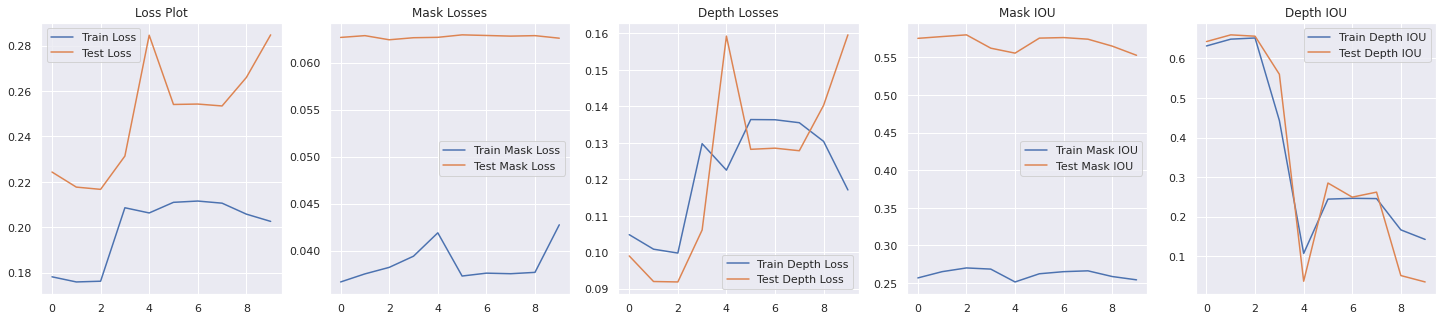

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
    
figure = plt.figure(figsize=(25,5))

plt.subplot(1,5,1)
plt.title("Loss Plot")
plt.plot(train_loss_all,label='Train Loss')
plt.plot(test_loss_all, label='Test Loss')
plt.legend(loc="best")

plt.subplot(1,5,2)
plt.title("Mask Losses")
plt.plot(train_mask_loss_all,label='Train Mask Loss')
plt.plot(test_mask_loss_all, label='Test Mask Loss')
plt.legend(loc="best")

plt.subplot(1,5,3)
plt.title("Depth Losses")
plt.plot(train_depth_loss_all,label='Train Depth Loss')
plt.plot(test_depth_loss_all, label='Test Depth Loss')
plt.legend(loc="best")

plt.subplot(1,5,4)
plt.title("Mask IOU")
plt.plot(train_mask_iou_all,label='Train Mask IOU')
plt.plot(test_mask_iou_all, label='Test Mask IOU')
plt.legend(loc="best")

plt.subplot(1,5,5)
plt.title("Depth IOU")
plt.plot(train_depth_iou_all,label='Train Depth IOU')
plt.plot(test_depth_iou_all, label='Test Depth IOU')
plt.legend(loc="best")